In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from main import (
    create_packets, sort_packets, Packet, PacketOutput, LCFS_S, LCFS_W, ProposedPolicy, LCFS_S_Incorrect, LCFS_W_Incorrect,
    get_outputs_by_source, calculate_average_age_information, get_age_of_information_updates
)

In [2]:
def ProposedPolicyModel(mu, p0, p1):
    def psi_0(pi):
        return p1**4 + 2*pi**3 + 3*pi**2 + 2*pi + 1

    def psi_1(pi):
        return 7*pi**4 + 15*pi**3 + 21*pi**2 + 14*pi + 6

    def psi_2(pi):
        return 17*pi**4 + 46*pi**3 + 64*pi**2 + 42*pi + 16

    def psi_3(pi):
        return 15*pi**4 + 73*pi**3 + 118*pi**2 + 78*pi + 26

    def psi_4(pi):
        return 5*pi**4 + 52*pi**3 + 124*pi**2 + 102*pi + 30

    def psi_5(pi):
        return 15*pi**3 + 66*pi**2 + 79*pi + 24

    def psi_6(pi):
        return 15*pi**2 + 31*pi + 11

    def psi_7(pi):
        return 5*pi + 2

    def xi_0(pi):
        return pi**4 + 2*pi**3 + 3*pi**2 + 2*pi + 1

    def xi_1(pi):
        return 2*pi**4 + 6*pi**3 + 9*pi**2 + 7*pi + 3

    def xi_2(pi):
        return 6*pi**3 + 12*pi**2 + 10*pi + 4

    def xi_3(pi):
        return 6*pi**2 + 8*pi + 3

    def xi_4(pi):
        return 2*pi + 1
    
    psi = [psi_0, psi_1, psi_2, psi_3, psi_4, psi_5, psi_6, psi_7]
    xi = [xi_0, xi_1, xi_2, xi_3, xi_4]

    numerator_0 = 0
    numerator_1 = 0
    for i in range(0, 8):
        numerator_0 += (p0**i)*(psi[i](p1))
        numerator_1 += (p1**i)*(psi[i](p0))
    
    denominator_0 = 0
    denominator_1 = 0
    for i in range(0, 5):
        denominator_0 += (p0**i)*(xi[i](p1))
        denominator_1 += (p1**i)*(xi[i](p0))

    denominator_0 *= ((mu*p0)*(1 + p0)**2)
    denominator_1 *= ((mu*p1)*(1 + p1)**2)

    return numerator_0/denominator_0 + numerator_1/denominator_1

def LCFS_S_Model(mu, p0, p1):
    p = p0 + p1
    def delta(pi):
        return (1/mu)*(1 + p)*(1/pi)

    return delta(p0) + delta(p1)

def LCFS_W_Model(mu, p0, p1):
    p = p0 + p1

    def aw(p):
        return ((((1 + p + p**2)**2) + 2*(p**3))/((1 + p + p**2)*((1 + p)**2)))
    
    def delta(pi):
        return (1/mu)*(aw(p) + (1 + ((p**2)/(1 + p)))*(1/pi))
    
    return delta(p0) + delta(p1)


In [10]:
POLICIES = [
    ("sim_proposed_policy", ProposedPolicy()),
    # ("sim_lcfs_s", LCFS_S()),
    # ("sim_lcfs_w", LCFS_W()),
    ("sim_lcfs_s_incorrect", LCFS_S_Incorrect()),
    ("sim_lcfs_w_incorrect", LCFS_W_Incorrect())
]

In [11]:
def fig2(p: float, p0_min: float, p0_max: float, p0_step: float, time: float, ylim=None, plot_original_functions: bool = False):
    plt.figure(figsize=(9, 6))
    colors = {
        "sim_proposed_policy": "tab:blue",
        "sim_lcfs_s": "tab:orange",
        "sim_lcfs_w": "tab:green",
        "sim_lcfs_s_incorrect": "tab:orange",
        "sim_lcfs_w_incorrect": "tab:green", 
    }
    
    service_time_mean = 1
    p0 = p0_min

    data = {
        policy_name: [] for policy_name, _ in POLICIES
    }

    while p0 <= p0_max:
        p1 = p - p0
        
        packets = sort_packets(
            create_packets(max_arrival_time=time, source=0, arrival_rate=p0, service_time_mean=1, seed=0), 
            create_packets(max_arrival_time=time, source=1, arrival_rate=p1, service_time_mean=1, seed=1),
        )
            
        for policy_name, policy in POLICIES:
            outputs = policy.simulate(packets)
            s0_aoi = calculate_average_age_information(outputs, source=0)
            s1_aoi = calculate_average_age_information(outputs, source=1)
   
            sum_aoi = s0_aoi + s1_aoi

            data[policy_name].append((p0, sum_aoi))
        

        p0 += p0_step

    for policy_name, points in data.items():
        plt.plot([x for x, _ in points], [y for _, y in points], label=f'{policy_name}', marker='o', markersize=3, c=colors[policy_name])
    
    if plot_original_functions:
        X = [x for x, _ in data['sim_proposed_policy']]

        plt.plot(X, [LCFS_S_Model(1, p - p1, p1) for p1 in X], label=f'theoretical_lcfs_s', linestyle=":", c=colors["sim_lcfs_s"], alpha=0.75)
        plt.plot(X, [LCFS_W_Model(1, p - p1, p1) for p1 in X], label=f'theoretical_lcfs_w', linestyle=":", c=colors["sim_lcfs_w"], alpha=0.75)
        plt.plot(X, [ProposedPolicyModel(1, p - p1, p1) for p1 in X], label=f'theoretical_proposed_policy', linestyle=":", c=colors["sim_proposed_policy"], alpha=0.75)

    plt.title(f'p={p}')

    plt.xlabel('p0')
    plt.ylim(ylim)
    plt.ylabel('Sum Average AoI')
    plt.legend()
    plt.show()

    return data

In [12]:
# data = fig2(p=0.9, p0_min=0.02, p0_max=0.88, p0_step=0.01, time=25_000, ylim=(7, 11))

In [13]:
# data = fig2(p=6, p0_min=0.05, p0_max=5.95, p0_step=0.1, time=25_000, ylim=(4, 10))

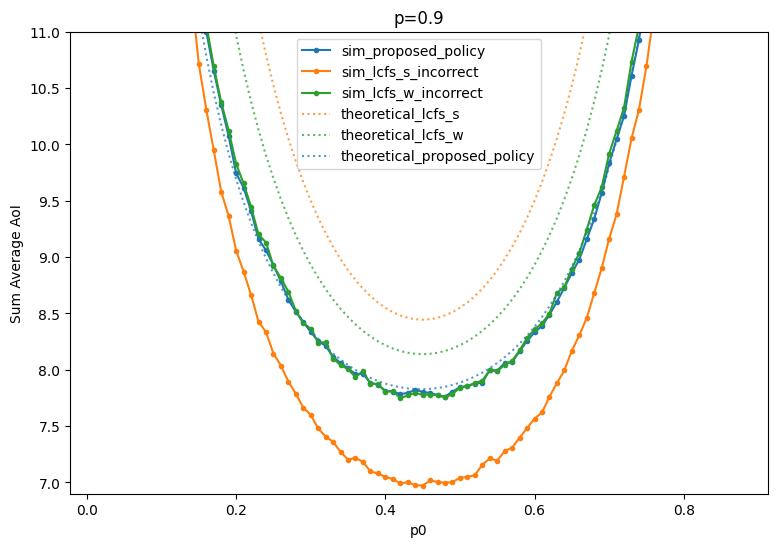

In [14]:
data = fig2(p=0.9, p0_min=0.02, p0_max=0.88, p0_step=0.01, time=25_000, ylim=(6.9, 11), plot_original_functions=True)

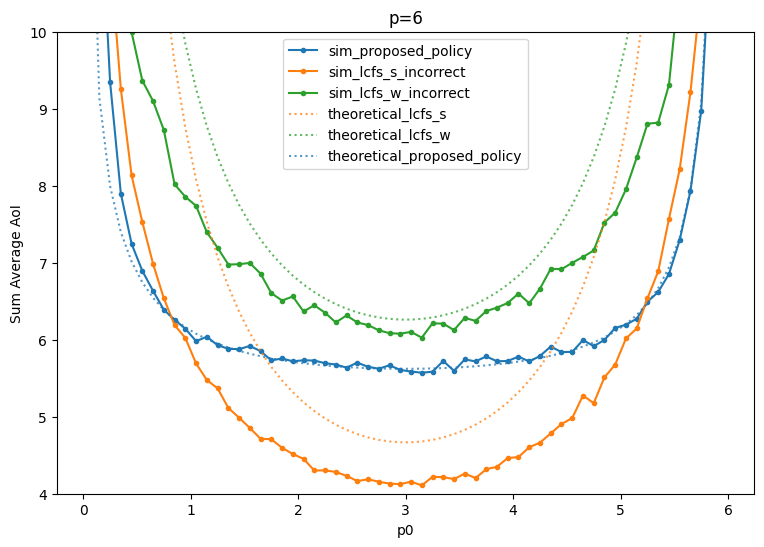

In [15]:
data = fig2(p=6, p0_min=0.05, p0_max=5.95, p0_step=0.1, time=10_000, ylim=(4, 10), plot_original_functions=True)

In [ ]:
def plot_age_of_information(outputs: list[PacketOutput], sources: list[int], plot_average=False):
    colors = ['r', 'b']
    max_time = max(output.service_end_time for output in outputs)

    sum_avg = 0
    
    for source in sources:
        updates = get_age_of_information_updates(outputs, source)
        
        if len(updates) < 1:
            continue
        
        plt.plot([x for x, _ in updates], [y for _, y in updates], label=f'source {source}', c=colors[source], alpha=1)
        
        if plot_average:
            avg = calculate_average_age_information(outputs, source)
            sum_avg += avg
            plt.plot((0, max_time), (avg, avg), label=f'source {source} avg', c=colors[source], alpha=0.5)
            

    plt.title('age of information vs. time')
    plt.xlabel('time')
    plt.ylabel('age of information')
    plt.legend()
    plt.show()
    return sum_avg

In [ ]:
packets = sort_packets(
    create_packets(max_arrival_time=100, source=0, arrival_rate=0.1, service_time_mean=1), 
    create_packets(max_arrival_time=100, source=1, arrival_rate=0.80, service_time_mean=1),
)

In [ ]:
outputs = LCFS_W().simulate(packets)
plot_age_of_information(outputs, sources=[0, 1], plot_average=True)

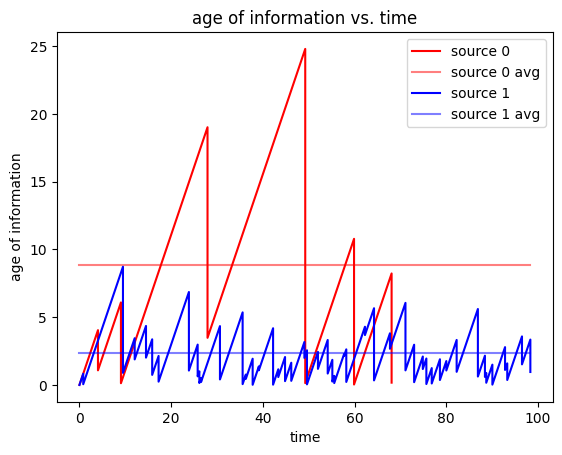

11.185934852568543

In [12]:
outputs = LCFS_S().simulate(packets)
plot_age_of_information(outputs, sources=[0, 1], plot_average=True)

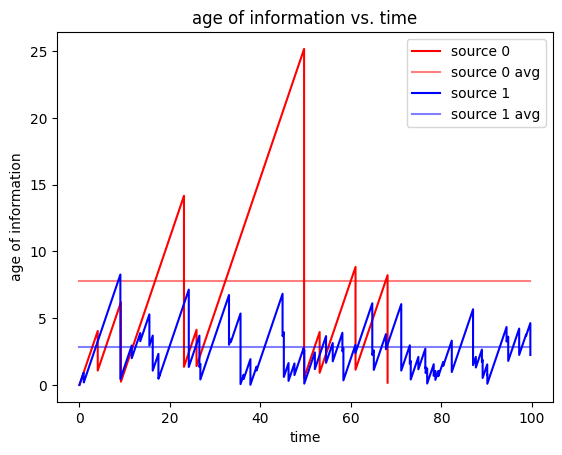

10.619788396374126

In [13]:
outputs = ProposedPolicy().simulate(packets)
plot_age_of_information(outputs, sources=[0, 1], plot_average=True)

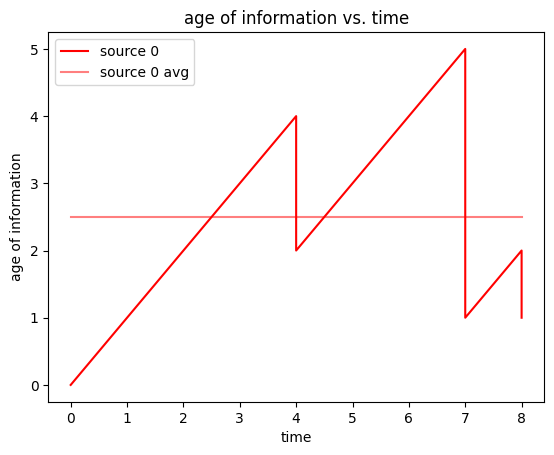

[AoiUpdate(time=0, age=0),
 AoiUpdate(time=4, age=4),
 AoiUpdate(time=4, age=2),
 AoiUpdate(time=7, age=5),
 AoiUpdate(time=7, age=1),
 AoiUpdate(time=8, age=2),
 AoiUpdate(time=8, age=1)]

In [14]:
dummy_output = [
    PacketOutput(source=0, arrival_time=2, service_end_time=4),
    PacketOutput(source=0, arrival_time=6, service_end_time=7),
    PacketOutput(source=0, arrival_time=7, service_end_time=8),
]
plot_age_of_information(dummy_output, sources=[0], 
    plot_average=True)

updates = get_age_of_information_updates(dummy_output, source=0)
updates